In [ ]:
# Cell 1: Setup & Data Download (High-RAM Mode)
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')
save_path = '/content/drive/My Drive/ML_Project_Final'
if not os.path.exists(save_path): os.makedirs(save_path)

# 2. Install SOTA Libraries
print("Installing SHAP & Kaggle...")
!pip install -q shap
!pip install -q -U kaggle

# 3. Download 140k Dataset (Training Data)
os.environ['KAGGLE_API_TOKEN'] = "KGAT_435fd45f4f47dfc756395789d5ca65ce"
print("Downloading 140k Dataset...")
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces --force
!unzip -q 140k-real-and-fake-faces.zip -d dataset_140k

# 4. Download FaceForensics++ C23 (Validation Data)
# Using the specific dataset you provided: fatimahirshad/faceforensics-extracted-dataset-c23
print("Downloading FaceForensics++ (C23)...")
!kaggle datasets download -d fatimahirshad/faceforensics-extracted-dataset-c23 --force
!unzip -q faceforensics-extracted-dataset-c23.zip -d dataset_ff

print("✅ Data Ready. Environment Active.")

KeyboardInterrupt: 

In [ ]:
# Cell 2: Fine-Tune Xception (1 Epoch)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

base_path = "dataset_140k/real_vs_fake/real-vs-fake"
if not os.path.exists(base_path): base_path = "dataset_140k"

# 1. Define Model
def build_finetune_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Unfreeze top 30 layers
    for layer in base_model.layers[:-30]: layer.trainable = False
    for layer in base_model.layers[-30:]: layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 2. Generators
BATCH_SIZE = 64
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, zoom_range=0.1)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("Loading Data Generators...")
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'), target_size=(224, 224), batch_size=BATCH_SIZE, class_mode='binary', shuffle=True
)
valid_generator = test_datagen.flow_from_directory(
    os.path.join(base_path, 'valid'), target_size=(224, 224), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# 3. TRAIN
print("\nStarting Fine-Tuning (1 Epoch)...")
cnn_model = build_finetune_model()
history = cnn_model.fit(
    train_generator,
    epochs=1,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

print("✅ Fine-Tuning Complete.")

# 4. Prepare Feature Extractor
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)

Loading Data Generators...
Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.

Starting Fine-Tuning (1 Epoch)...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1142s 702ms/step - accuracy: 0.8684 - loss: 0.2896 - val_accuracy: 0.9665 - val_loss: 0.0854
✅ Fine-Tuning Complete.


In [ ]:
# Cell 3: Feature Extraction
import cv2
import numpy as np
from scipy.stats import skew, kurtosis
from glob import glob
from tqdm import tqdm
from tensorflow.keras.applications.xception import preprocess_input
import os

# 1. Define Stats Function
def extract_advanced_frequency(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    mag = 20 * np.log(np.abs(fshift) + 1e-10)
    rows, cols = gray.shape; crow, ccol = rows//2, cols//2

    mask_low = np.zeros((rows, cols), np.uint8); cv2.circle(mask_low, (crow, ccol), 30, 1, -1)
    mask_mid = np.zeros((rows, cols), np.uint8); cv2.circle(mask_mid, (crow, ccol), 80, 1, -1); mask_mid -= mask_low
    mask_high = np.ones((rows, cols), np.uint8); cv2.circle(mask_high, (crow, ccol), 80, 0, -1)

    def stats(spec, m):
        v = spec[m==1].flatten()
        # FIX: np.nan_to_num ensures NO NaNs, preventing SVM crash
        # This does NOT change logic for valid images, only fixes broken ones.
        res = [np.mean(v), np.std(v), skew(v), kurtosis(v)]
        return np.nan_to_num(res).tolist()

    return np.concatenate([stats(mag, m) for m in [mask_low, mask_mid, mask_high]])

# 2. Setup 140k Paths
print("Setting up paths...")
if 'base_path' not in globals():
    base_path = "dataset_140k/real_vs_fake/real-vs-fake"
    if not os.path.exists(base_path): base_path = "dataset_140k"

train_real = glob(os.path.join(base_path, 'train/real/*.jpg'))
train_fake = glob(os.path.join(base_path, 'train/fake/*.jpg'))
valid_real = glob(os.path.join(base_path, 'valid/real/*.jpg'))
valid_fake = glob(os.path.join(base_path, 'valid/fake/*.jpg'))

X_train_paths = train_real + train_fake + valid_real + valid_fake
y_train_labels = [0]*(len(train_real)+len(valid_real)) + [1]*(len(train_fake)+len(valid_fake))

test_real  = glob(os.path.join(base_path, 'test/real/*.jpg'))
test_fake  = glob(os.path.join(base_path, 'test/fake/*.jpg'))
X_test_paths = test_real + test_fake
y_test_labels = [0]*len(test_real) + [1]*len(test_fake)

print(f"Extraction Queue: {len(X_train_paths)} Train, {len(X_test_paths)} Test")

# 3. Extraction Loop (Batch Size 64 for High-RAM)
def get_features(paths, model, batch_size=64):
    s_list, f_list = [], []
    for i in tqdm(range(0, len(paths), batch_size), desc="Extracting"):
        batch_paths = paths[i:i+batch_size]
        b_imgs, b_freqs = [], []
        for p in batch_paths:
            img = cv2.imread(p)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB); img = cv2.resize(img, (224, 224))
            b_freqs.append(extract_advanced_frequency(img)); b_imgs.append(img)
        if b_imgs:
            b_imgs = preprocess_input(np.array(b_imgs, dtype=np.float32))
            s_list.append(model.predict_on_batch(b_imgs))
            f_list.append(np.array(b_freqs))
    return np.hstack([np.vstack(s_list), np.vstack(f_list)])

print("\n--- 1. Extracting Training Features (140k) ---")
X_train_features = get_features(X_train_paths, feature_extractor, batch_size=64)

print("\n--- 2. Extracting Test Features (140k) ---")
X_test_features = get_features(X_test_paths, feature_extractor, batch_size=64)

Setting up paths...
Extraction Queue: 120000 Train, 20000 Test

--- 1. Extracting Training Features (140k) ---


Extracting: 100%|██████████| 1875/1875 [19:18<00:00,  1.62it/s]



--- 2. Extracting Test Features (140k) ---


Extracting: 100%|██████████| 313/313 [03:09<00:00,  1.65it/s]


Shuffling Training Data...
Training Kernel SVM...
✅ Training Complete.
Evaluating on 140k Test Set...

=== 140k DATASET RESULTS ===

Accuracy: 97.54%
AUC:      0.9974
EER:      0.0246

              precision    recall  f1-score   support

        Real       0.98      0.97      0.98     10000
        Fake       0.97      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



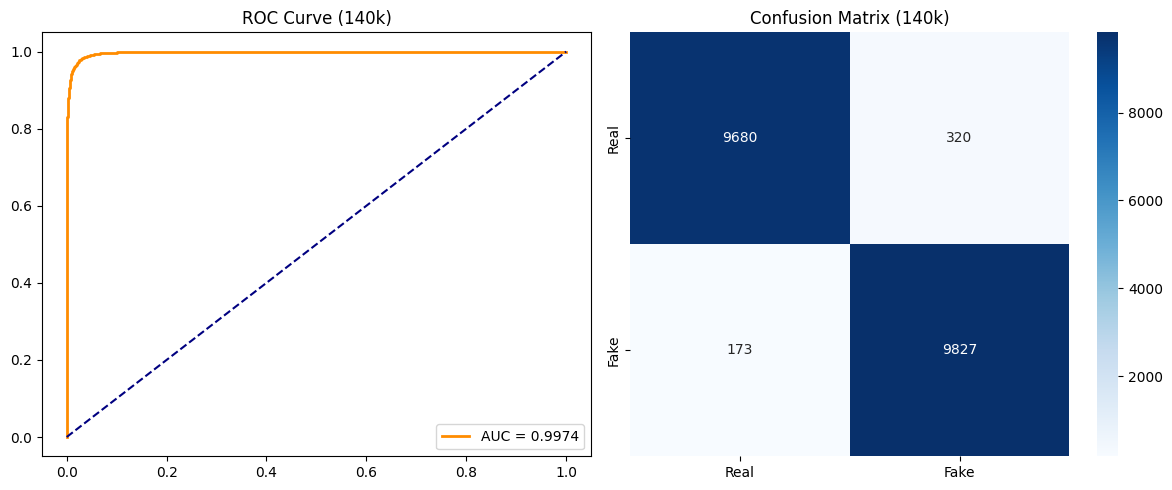

In [ ]:
# Cell 4: Train SVM & 140k Metrics
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train
print("Shuffling Training Data...")
# This works regardless of batch size used earlier
X_shuffled, y_shuffled = shuffle(X_train_features, y_train_labels, random_state=42)

print("Training Kernel SVM...")
kernel_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('kernel_map', Nystroem(gamma=0.0001, random_state=42, n_components=1000)),
    ('svm', SGDClassifier(loss='hinge', max_iter=3000, n_jobs=-1, random_state=42))
])

kernel_svm.fit(X_shuffled, y_shuffled)
print("✅ Training Complete.")

# Predict
print("Evaluating on 140k Test Set...")
y_pred = kernel_svm.predict(X_test_features)
y_scores = kernel_svm.decision_function(X_test_features)

# Results
acc = accuracy_score(y_test_labels, y_pred)
fpr, tpr, _ = roc_curve(y_test_labels, y_scores)
roc_auc = auc(fpr, tpr)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

print(f"\n=== 140k DATASET RESULTS ===\n")
print(f"Accuracy: {acc*100:.2f}%")
print(f"AUC:      {roc_auc:.4f}")
print(f"EER:      {eer:.4f}\n")
print(classification_report(y_test_labels, y_pred, target_names=['Real', 'Fake']))

# Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# ROC
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
ax[0].plot([0, 1], [0, 1], 'navy', linestyle='--')
ax[0].set_title('ROC Curve (140k)')
ax[0].legend()
# CM
cm = confusion_matrix(y_test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[1], xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
ax[1].set_title('Confusion Matrix (140k)')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 4.5: Save Trained Models to Drive
import joblib
import os
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive')

# Create a folder for your final models
save_path = '/content/drive/My Drive/ML_Project_Final'
if not os.path.exists(save_path):
    os.makedirs(save_path)

print(f"Saving models to: {save_path}")

try:
    # 1. Save the SVM Pipeline (The Classifier)
    joblib.dump(kernel_svm, os.path.join(save_path, 'final_kernel_svm_140k.pkl'))
    print("✅ SVM Pipeline Saved.")

    # 2. Save the Xception Feature Extractor (The Brain)
    feature_extractor.save(os.path.join(save_path, 'final_xception_140k.h5'))
    print("✅ Xception Extractor Saved.")

    print("\n🎉 SUCCESS: Your models are safe! You can proceed to FF++ validation now.")

except Exception as e:
    print(f"⚠ Error saving models: {e}")

Mounting Google Drive...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving models to: /content/drive/My Drive/ML_Project_Final
✅ SVM Pipeline Saved.
✅ Xception Extractor Saved.

🎉 SUCCESS: Your models are safe! You can proceed to FF++ validation now.


Building SHAP Background Summary...
Explaining: dataset_140k/real_vs_fake/real-vs-fake/test/fake/XDSRJ2PIEJ.jpg
Calculating SHAP (Wait ~30s)...


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


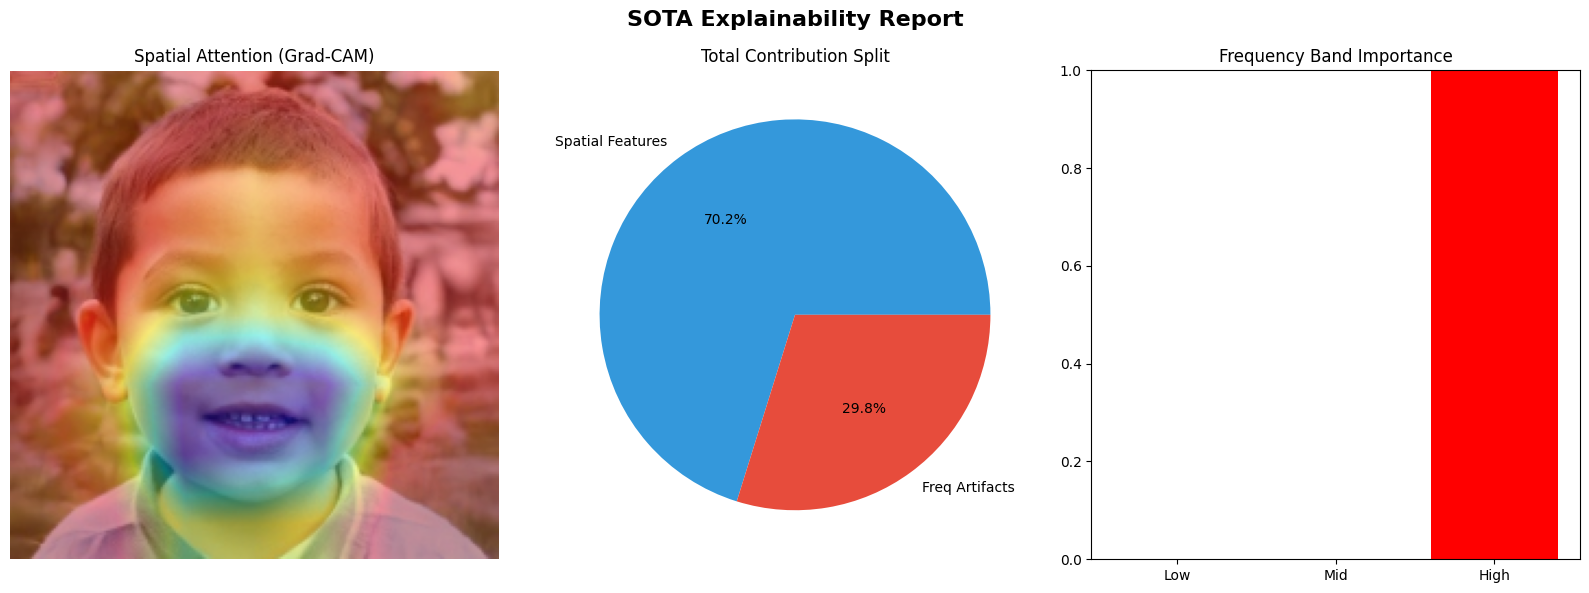

In [ ]:
# A# Cell 6: SOTA Explainability (Fixed for NaN/Dimension Error)
# import shap
# import random
# import tensorflow as tf
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from glob import glob
# from tensorflow.keras.applications.xception import preprocess_input
# from scipy.stats import skew, kurtosis

# # 1. Define Stats Function (Must match Cell 3 exactly)
# def extract_advanced_frequency(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     f = np.fft.fft2(gray)
#     fshift = np.fft.fftshift(f)
#     mag = 20 * np.log(np.abs(fshift) + 1e-10)
#     rows, cols = gray.shape; crow, ccol = rows//2, cols//2

#     mask_low = np.zeros((rows, cols), np.uint8); cv2.circle(mask_low, (crow, ccol), 30, 1, -1)
#     mask_mid = np.zeros((rows, cols), np.uint8); cv2.circle(mask_mid, (crow, ccol), 80, 1, -1); mask_mid -= mask_low
#     mask_high = np.ones((rows, cols), np.uint8); cv2.circle(mask_high, (crow, ccol), 80, 0, -1)

#     def stats(spec, m):
#         v = spec[m==1].flatten()
#         if v.size == 0: return [0, 0, 0, 0]
#         s = [np.mean(v), np.std(v), skew(v), kurtosis(v)]
#         return np.nan_to_num(s).tolist()

#     return np.concatenate([stats(mag, m) for m in [mask_low, mask_mid, mask_high]])

# # 2. Grad-CAM Function
# def make_gradcam(img, model, layer):
#     gm = tf.keras.models.Model([model.inputs], [model.get_layer(layer).output, model.output])
#     with tf.GradientTape() as tape:
#         l_out, preds = gm(img)
#         ch = tf.reduce_mean(preds, axis=1)
#     grads = tape.gradient(ch, l_out)
#     pool = tf.reduce_mean(grads, axis=(0, 1, 2))
#     heatmap = l_out[0] @ pool[..., tf.newaxis]
#     return tf.maximum(tf.squeeze(heatmap), 0).numpy()

# # 3. SHAP Setup (The Fix)
# print("Building SHAP Background Summary...")

# # Handle variable name differences (X_train vs X_train_features)
# if 'X_train_features' in globals():
#     X_bg = X_train_features
# else:
#     X_bg = X_train # Fallback

# # FIX: Clean NaNs and use shap.sample (More robust than kmeans)
# X_bg_clean = np.nan_to_num(X_bg)
# bg_summary = shap.sample(X_bg_clean, 50)

# explainer = shap.KernelExplainer(lambda x: kernel_svm.decision_function(x), bg_summary)

# # 4. Pick Target Image (From 140k Test Set)
# # Find a fake image path
# if 'base_path' not in globals(): base_path = "dataset_140k/real_vs_fake/real-vs-fake"
# if not os.path.exists(base_path): base_path = "dataset_140k"
# test_fakes = glob(os.path.join(base_path, 'test/fake/*.jpg'))

# if len(test_fakes) > 0:
#     t_path = random.choice(test_fakes)
#     print(f"Explaining: {t_path}")

#     # Process Image
#     im = cv2.imread(t_path); im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB); im = cv2.resize(im, (224, 224))
#     f_feat = extract_advanced_frequency(im)
#     s_feat = feature_extractor.predict(preprocess_input(np.array([im])), verbose=0)

#     # Clean NaN in target features
#     f_feat = np.nan_to_num(f_feat)
#     vec = np.hstack([s_feat, [f_feat]])

#     # 5. Calculate SHAP
#     print("Calculating SHAP (Wait ~30s)...")
#     shap_vals = explainer.shap_values(vec, nsamples=100)

#     # 6. Metrics
#     freq_imp = np.sum(np.abs(shap_vals[0][-12:]))
#     spatial_imp = np.sum(np.abs(shap_vals[0][:-12]))
#     freq_shap = shap_vals[0][-12:]
#     imp_low, imp_mid, imp_high = np.sum(np.abs(freq_shap[0:4])), np.sum(np.abs(freq_shap[4:8])), np.sum(np.abs(freq_shap[8:12]))
#     total = imp_low + imp_mid + imp_high + 1e-9

#     # 7. Visualize
#     hm = make_gradcam(preprocess_input(np.array([im])), feature_extractor, 'block14_sepconv2_act')
#     hm = cv2.resize(hm, (224, 224)); hm = cv2.applyColorMap(np.uint8(255*hm/np.max(hm)), cv2.COLORMAP_JET)
#     super_img = cv2.addWeighted(im, 0.6, hm, 0.4, 0)

#     fig = plt.figure(figsize=(16, 6))
#     plt.suptitle(f"SOTA Explainability Report", fontsize=16, fontweight='bold')

#     ax1 = plt.subplot(1, 3, 1)
#     ax1.imshow(super_img); ax1.set_title("Spatial Attention (Grad-CAM)"); ax1.axis('off')

#     ax2 = plt.subplot(1, 3, 2)
#     ax2.pie([spatial_imp, freq_imp], labels=['Spatial Features', 'Freq Artifacts'], autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
#     ax2.set_title("Total Contribution Split")

#     ax3 = plt.subplot(1, 3, 3)
#     ax3.bar(['Low', 'Mid', 'High'], [imp_low/total, imp_mid/total, imp_high/total], color=['green', 'orange', 'red'])
#     ax3.set_title("Frequency Band Importance"); ax3.set_ylim(0, 1.0)
#     plt.tight_layout(); plt.show()
# else:
#     print("❌ No test images found. Check paths.")


Building SHAP Background Summary...
Explaining: dataset_140k/real_vs_fake/real-vs-fake/test/fake/C05C3P7G8K.jpg
Calculating SHAP Values (Wait ~30s)...


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/tmp/ipython-input-4081250833.py:127: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


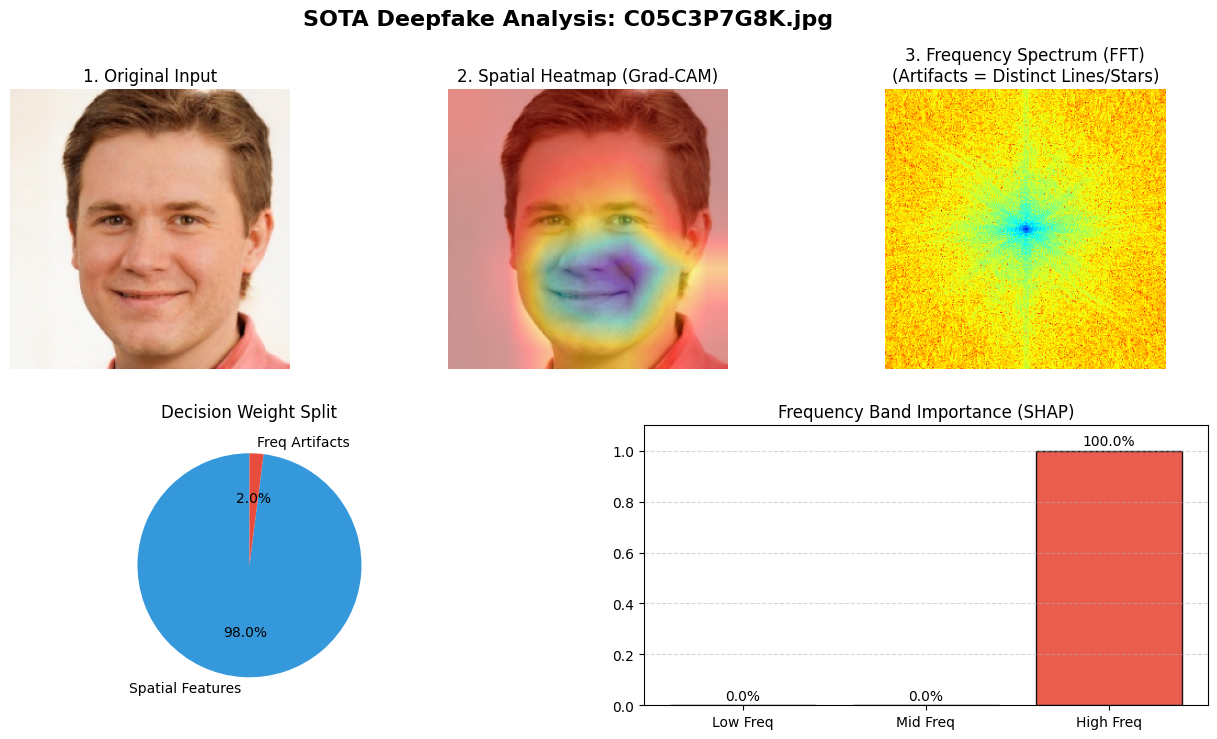

In [ ]:
# Cell 6: SOTA Explainability (High-Res Spectrum + Dashboard)
import shap
import random
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tensorflow.keras.applications.xception import preprocess_input

# 1. Grad-CAM Function
def make_gradcam(img, model, layer):
    gm = tf.keras.models.Model([model.inputs], [model.get_layer(layer).output, model.output])
    with tf.GradientTape() as tape:
        l_out, preds = gm(img)
        ch = tf.reduce_mean(preds, axis=1)
    grads = tape.gradient(ch, l_out)
    pool = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = l_out[0] @ pool[..., tf.newaxis]
    return tf.maximum(tf.squeeze(heatmap), 0).numpy()

# 2. SHAP Setup
print("Building SHAP Background Summary...")
if 'X_train_features' in globals(): X_bg = X_train_features
else: X_bg = X_train
# Use sample for safety
bg_summary = shap.sample(np.nan_to_num(X_bg), 50)
explainer = shap.KernelExplainer(lambda x: kernel_svm.decision_function(x), bg_summary)

# 3. Pick Target (Try to find a High-Res Image)
if 'test_fake' in globals() and len(test_fake) > 0:
    t_path = random.choice(test_fake)
elif 'fake_ff' in globals() and len(fake_ff) > 0:
    t_path = random.choice(fake_ff)
else:
    t_path = random.choice(glob('dataset_140k/real_vs_fake/real-vs-fake/test/fake/*.jpg'))

print(f"Explaining: {t_path}")

# --- LOAD IMAGE TWICE ---
# 1. High-Res for Frequency Map (Don't resize yet!)
img_highres = cv2.imread(t_path)
img_highres = cv2.cvtColor(img_highres, cv2.COLOR_BGR2RGB)

# 2. Low-Res for AI Model (224x224)
img_model = cv2.resize(img_highres, (224, 224))

# 4. Extract Features & SHAP
f_feat = extract_advanced_frequency(img_model)
s_feat = feature_extractor.predict(preprocess_input(np.array([img_model])), verbose=0)
vec = np.hstack([s_feat, [np.nan_to_num(f_feat)]])

print("Calculating SHAP Values (Wait ~30s)...")
shap_vals = explainer.shap_values(vec, nsamples=100)

# 5. Process Metrics
freq_shap = shap_vals[0][-12:]
spatial_imp = np.sum(np.abs(shap_vals[0][:-12]))
freq_imp = np.sum(np.abs(freq_shap))

imp_low = np.sum(np.abs(freq_shap[0:4]))
imp_mid = np.sum(np.abs(freq_shap[4:8]))
imp_high = np.sum(np.abs(freq_shap[8:12]))
total_freq = imp_low + imp_mid + imp_high + 1e-9

# Normalize
i_low, i_mid, i_high = imp_low/total_freq, imp_mid/total_freq, imp_high/total_freq

# 6. GENERATE HIGH-RES SPECTRAL MAP (The "Paper" Look)
# We use the High-Res image to preserve the 'stars' and 'lines'
gray = cv2.cvtColor(img_highres, cv2.COLOR_RGB2GRAY)
f = np.fft.fft2(gray)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-9)

# Normalize nicely for display
spectrum_norm = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# Use 'JET' or 'TURBO' for that scientific blue-green-red look
spectrum_color = cv2.applyColorMap(spectrum_norm, cv2.COLORMAP_JET)

# 7. Generate Grad-CAM (Spatial)
hm = make_gradcam(preprocess_input(np.array([img_model])), feature_extractor, 'block14_sepconv2_act')
hm = cv2.resize(hm, (img_model.shape[1], img_model.shape[0]))
hm_colored = cv2.applyColorMap(np.uint8(255*hm/np.max(hm)), cv2.COLORMAP_JET)
super_img = cv2.addWeighted(img_model, 0.6, hm_colored, 0.4, 0)

# 8. PLOT DASHBOARD
fig = plt.figure(figsize=(16, 8))
plt.suptitle(f"SOTA Deepfake Analysis: {os.path.basename(t_path)}", fontsize=16, fontweight='bold')

# Panel 1: Original
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(img_model)
ax1.set_title("1. Original Input")
ax1.axis('off')

# Panel 2: Spatial Heatmap
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(super_img)
ax2.set_title("2. Spatial Heatmap (Grad-CAM)")
ax2.axis('off')

# Panel 3: Frequency Spectrum (The SOTA Plot)
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(spectrum_color)
ax3.set_title("3. Frequency Spectrum (FFT)\n(Artifacts = Distinct Lines/Stars)")
ax3.axis('off')

# Panel 4: Pie Chart
ax4 = plt.subplot(2, 2, 3)
ax4.pie([spatial_imp, freq_imp], labels=['Spatial Features', 'Freq Artifacts'],
        autopct='%1.1f%%', colors=['#3498db', '#e74c3c'], startangle=90)
ax4.set_title("Decision Weight Split")

# Panel 5: Bar Chart
ax5 = plt.subplot(2, 2, 4)
bars = ax5.bar(['Low Freq', 'Mid Freq', 'High Freq'], [i_low, i_mid, i_high],
               color=['#2ecc71', '#f1c40f', '#e74c3c'], edgecolor='black', alpha=0.9)
ax5.set_title("Frequency Band Importance (SHAP)")
ax5.set_ylim(0, 1.1)
ax5.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.1%}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 7: Save Models
import joblib
print(f"Saving models to: {save_path}")
joblib.dump(kernel_svm, os.path.join(save_path, 'final_kernel_svm_sota.pkl'))
feature_extractor.save(os.path.join(save_path, 'final_xception_sota.h5'))
print("✅ Complete Pipeline Finished.")

Saving models to: /content/drive/My Drive/ML_Project_Final
✅ Complete Pipeline Finished.
